In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, avg, when
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Create Spark session (Databricks already has one by default)
spark = SparkSession.builder.appName("SalesVisualization").getOrCreate()

In [0]:
schema = StructType([
    StructField("order_id", StringType()),
    StructField("region", StringType()),
    StructField("category", StringType()),
    StructField("quantity", IntegerType()),
    StructField("price", DoubleType()),
    StructField("order_date", DateType())
])

data = [
    ("O001", "South", "Electronics", 3, 15000, date(2025, 1, 5)),
    ("O002", "North", "Clothing", 5, 2000, date(2025, 1, 6)),
    ("O003", "East", "Furniture", 2, 12000, date(2025, 1, 7)),
    ("O004", "West", "Electronics", 1, 18000, date(2025, 1, 8)),
    ("O005", "North", "Furniture", 4, 9000, date(2025, 1, 10)),
    ("O006", "South", "Clothing", 6, 2500, date(2025, 1, 11)),
    ("O007", "East", "Electronics", 2, 17000, date(2025, 1, 12)),
    ("O008", "South", "Furniture", 5, 8500, date(2025, 1, 15)),
    ("O009", "West", "Clothing", 7, 3000, date(2025, 1, 17)),
    ("O010", "North", "Electronics", 4, 16000, date(2025, 1, 18))
]

df = spark.createDataFrame(data, schema)

1. Show first 10 rows

In [0]:
df.show(10, truncate=False)

+--------+------+-----------+--------+-------+----------+-------+
|order_id|region|category   |quantity|price  |order_date|revenue|
+--------+------+-----------+--------+-------+----------+-------+
|O001    |South |Electronics|3       |15000.0|2025-01-05|45000.0|
|O002    |North |Clothing   |5       |2000.0 |2025-01-06|10000.0|
|O003    |East  |Furniture  |2       |12000.0|2025-01-07|24000.0|
|O004    |West  |Electronics|1       |18000.0|2025-01-08|18000.0|
|O005    |North |Furniture  |4       |9000.0 |2025-01-10|36000.0|
|O006    |South |Clothing   |6       |2500.0 |2025-01-11|15000.0|
|O007    |East  |Electronics|2       |17000.0|2025-01-12|34000.0|
|O008    |South |Furniture  |5       |8500.0 |2025-01-15|42500.0|
|O009    |West  |Clothing   |7       |3000.0 |2025-01-17|21000.0|
|O010    |North |Electronics|4       |16000.0|2025-01-18|64000.0|
+--------+------+-----------+--------+-------+----------+-------+



In [0]:
# 2. Add revenue column
df = df.withColumn("revenue", col("quantity") * col("price"))

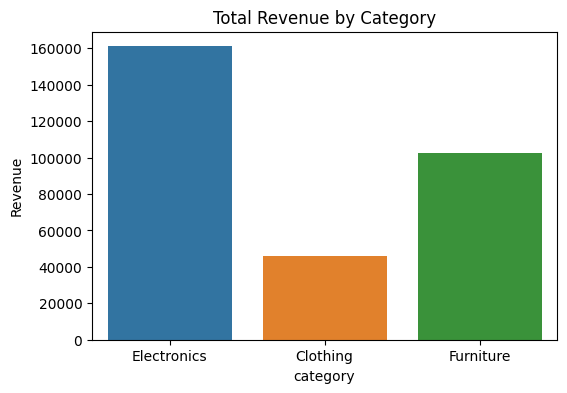

In [0]:
# 3. Bar chart - Revenue by Category
category_rev = df.groupBy("category").agg(_sum("revenue").alias("total_revenue")).toPandas()
plt.figure(figsize=(6,4))
sns.barplot(x="category", y="total_revenue", data=category_rev)
plt.title("Total Revenue by Category")
plt.ylabel("Revenue")
plt.show()
plt.close()


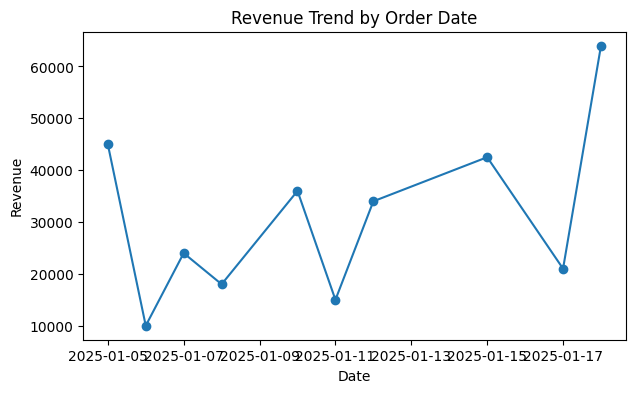

In [0]:
# 4. Line chart - Revenue trend by date
rev_trend = df.groupBy("order_date").agg(_sum("revenue").alias("total_revenue")).orderBy("order_date").toPandas()
plt.figure(figsize=(7,4))
plt.plot(rev_trend["order_date"], rev_trend["total_revenue"], marker="o")
plt.title("Revenue Trend by Order Date")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()
plt.close()

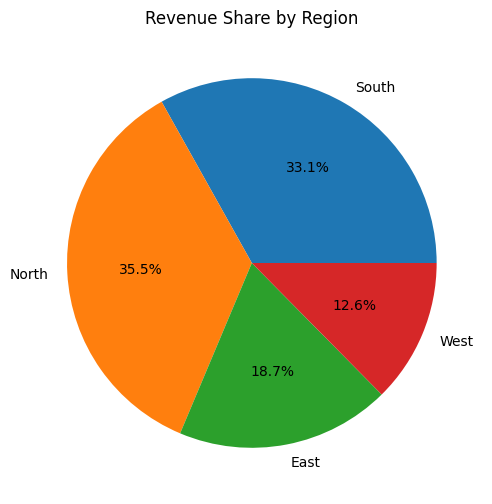

In [0]:
# 5. Pie chart - Revenue by Region
# ---------------------------
region_rev = df.groupBy("region").agg(_sum("revenue").alias("total_revenue")).toPandas()
plt.figure(figsize=(6,6))
plt.pie(region_rev["total_revenue"], labels=region_rev["region"], autopct='%1.1f%%')
plt.title("Revenue Share by Region")
plt.show()
plt.close()

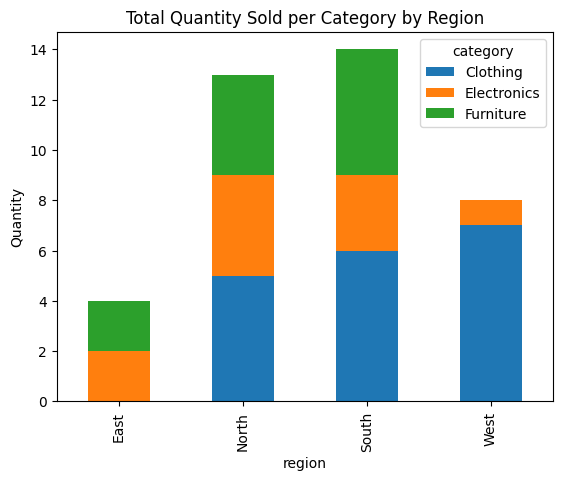

In [0]:
# 6. Stacked bar - Quantity per Category by Region
qty_stack = df.groupBy("region", "category").agg(_sum("quantity").alias("total_qty")).toPandas()
pivot_qty = qty_stack.pivot(index="region", columns="category", values="total_qty").fillna(0)
pivot_qty.plot(kind="bar", stacked=True)
plt.title("Total Quantity Sold per Category by Region")
plt.ylabel("Quantity")
plt.show()
plt.close()

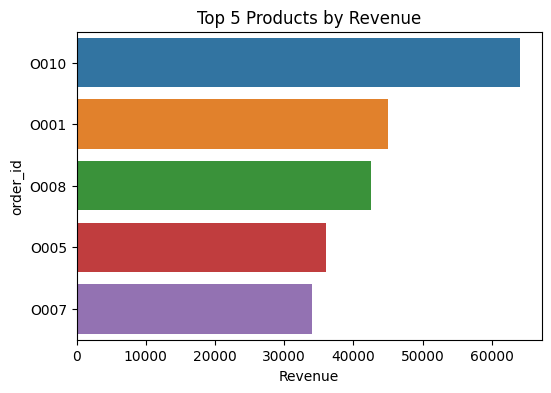

In [0]:
# 7. Horizontal bar - Top 5 products by revenue
top5 = df.groupBy("order_id").agg(_sum("revenue").alias("total_revenue")).orderBy(col("total_revenue").desc()).limit(5).toPandas()
plt.figure(figsize=(6,4))
sns.barplot(x="total_revenue", y="order_id", data=top5, orient="h")
plt.title("Top 5 Products by Revenue")
plt.xlabel("Revenue")
plt.show()
plt.close()

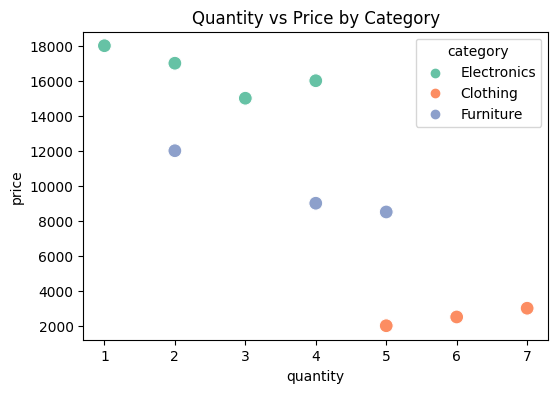

In [0]:
# 8. Scatter plot - Quantity vs Price colored by Category
df_pd = df.toPandas()
plt.figure(figsize=(6,4))
sns.scatterplot(x="quantity", y="price", hue="category", data=df_pd, palette="Set2", s=100)
plt.title("Quantity vs Price by Category")
plt.show()
plt.close()

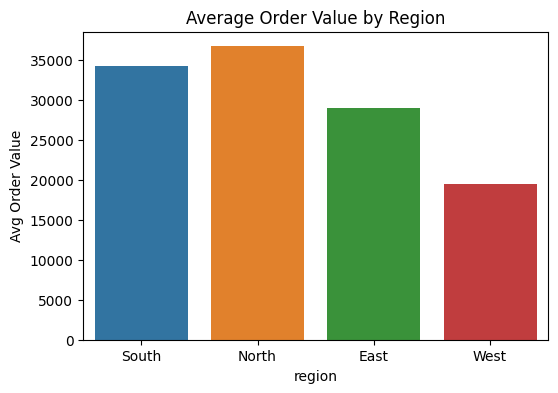

In [0]:
# 9. Bar chart - Average order value by Region
avg_order_val = df.groupBy("region").agg(avg("revenue").alias("avg_order_value")).toPandas()
plt.figure(figsize=(6,4))
sns.barplot(x="region", y="avg_order_value", data=avg_order_val)
plt.title("Average Order Value by Region")
plt.ylabel("Avg Order Value")
plt.show()
plt.close()

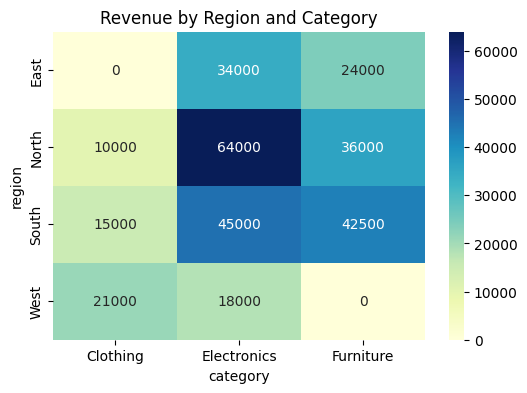

In [0]:
# 10. Heatmap - Revenue by Region and Category
heat_data = df.groupBy("region", "category").agg(_sum("revenue").alias("total_revenue")).toPandas()
pivot_heat = heat_data.pivot(index="region", columns="category", values="total_revenue").fillna(0)
plt.figure(figsize=(6,4))
sns.heatmap(pivot_heat, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Revenue by Region and Category")
plt.show()
plt.close()

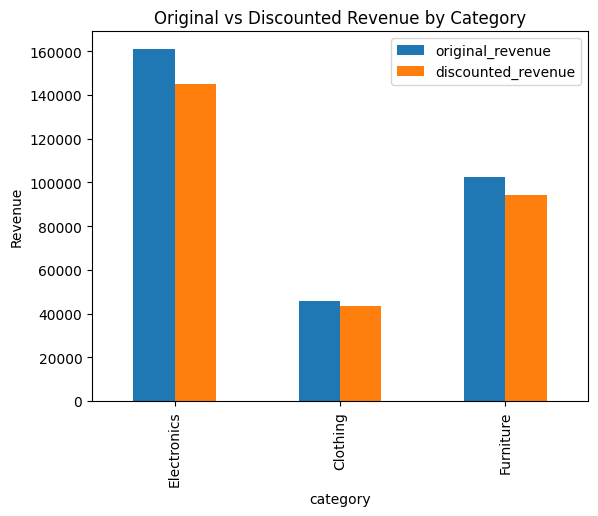

In [0]:
# 11. Discount column & Grouped bar chart
df_discount = df.withColumn("discount_percent", 
    when(col("category")=="Electronics", 0.10)
    .when(col("category")=="Clothing", 0.05)
    .when(col("category")=="Furniture", 0.08)
    .otherwise(0)
)
df_discount = df_discount.withColumn("discounted_revenue", col("revenue") * (1 - col("discount_percent")))

discount_pd = df_discount.groupBy("category").agg(
    _sum("revenue").alias("original_revenue"),
    _sum("discounted_revenue").alias("discounted_revenue")
).toPandas()

discount_pd.plot(x="category", y=["original_revenue", "discounted_revenue"], kind="bar")
plt.title("Original vs Discounted Revenue by Category")
plt.ylabel("Revenue")
plt.show()
plt.close()